In [9]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import delayed, Parallel
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['grid.color']='white'

In [2]:
all_features = pd.read_csv('../data/pdbbind_2018_general_all_features_clean.csv', index_col=0)
binding_data = pd.read_csv('../data/pdbbind_2018_general_binding_data_clean.csv', index_col=0, squeeze=True)

with open('../data/feature_sets.json') as f:
    feature_sets = json.load(f)

refined_sets = {}
general_sets = {}
for i in range(2013, 2019, 1):
    with open(f'../data/pdbbind_{i}_refined_pdbs.txt') as f:
        refined_sets[str(i)] = pd.Index([l.strip() for l in f]).intersection(all_features.index)
    with open(f'../data/pdbbind_{i}_general_pdbs.txt') as f:
        general_sets[str(i)] = pd.Index([l.strip() for l in f]).intersection(all_features.index)
with open('../data/pdbbind_all_core_pdbs.txt') as f:
    core_pdbs = pd.Index([l.strip() for l in f]).intersection(all_features.index)

Visualise correlations between RDKit and RF-Score v3 features

In [ ]:
grid_spec = {"width_ratios": (.9, .05)}
fig, (ax, cbar_ax) = plt.subplots(1,2, figsize=(40, 40), gridspec_kw=grid_spec) 

sns.heatmap(all_features[feature_sets['RF-Score v3 + RDKit']].corr(), 
            cmap='vlag', 
            center=0,
            ax=ax,
            cbar_ax=cbar_ax,
            vmin=-1,
            vmax=1,
            cbar_kws=dict(label='Pearson correlation coefficient'),
            xticklabels=False,
            yticklabels=False
           )
cbar_ax.yaxis.label.set_size(40)
for l in cbar_ax.yaxis.get_ticklabels():
    l.set_fontsize(40)
    
ax.hlines(42, *ax.get_xlim(), linestyle=':', linewidth=10)
ax.vlines(42, *ax.get_ylim(), linestyle=':', linewidth=10)

ax.text(0,0.93, 'RF-Score v3', fontsize=40,
        horizontalalignment='right',
        #verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)

ax.text(0.05,1, 'RF-Score v3', fontsize=40,
        verticalalignment='bottom',
        #verticalalignment='center',
        rotation='horizontal',
        transform=ax.transAxes)

ax.text(0,0.42, 'RDKit', fontsize=40,
        horizontalalignment='right',
        #verticalalignment='center',
        rotation='vertical',
        transform=ax.transAxes)

ax.text(0.58, 1, 'RDKit', fontsize=40,
        verticalalignment='bottom',
        #verticalalignment='center',
        rotation='horizontal',
        transform=ax.transAxes)


fig.tight_layout()
fig.savefig('../figures/correlation_matrix.eps', dpi=100, bbox_inches='tight')

In [73]:
# Sample 2013 refined for test sets

np.random.seed(42)
n_samples = 200
test_sets = [pd.Index(np.random.choice(refined_sets['2013'], size=200), replace=True) for _ in range(n_samples)]
training_sets = [refined_sets['2013'].difference(test) for test in test_sets]

In [109]:
test = pd.Index(core_pdbs)
train = all_features.index.difference(core_pdbs)

In [116]:
#rfv3

X_train = all_features.loc[train, feature_sets['RF-Score v3']].values
y_train = binding_data.loc[train].values.ravel()

X_test = all_features.loc[test, feature_sets['RF-Score v3']].values
y_test = binding_data.loc[test].values.ravel()

rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=90).fit(X_train, y_train)

rfv3_pred = rf.predict(X_test)

rfv3_diff = np.absolute(rfv3_pred - y_test)

X_train = all_features.loc[train, feature_sets['RF-Score v3 + RDKit']].values
y_train = binding_data.loc[train].values.ravel()

X_test = all_features.loc[test, feature_sets['RF-Score v3 + RDKit']].values
y_test = binding_data.loc[test].values.ravel()

rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=90).fit(X_train, y_train)

rfv3rdk_pred = rf.predict(X_test)

rfv3rdk_diff = np.absolute(rfv3rdk_pred - y_test)

In [118]:
error_difference = rfv3rdk_diff - rfv3_diff

In [126]:
# number of times rfv3+rdk has smaller error than rfv3
np.sign(error_difference)
sum([1 if i < 0 else 0 for i in error_difference])

285

In [134]:
from sklearn.metrics import mean_squared_error
import math

In [135]:
print(math.sqrt(mean_squared_error(y_test, rfv3_pred)))
print(math.sqrt(mean_squared_error(y_test, rfv3rdk_pred)))

1.4782933871609882
1.3761608664487357


In [5]:
@delayed
def fit_and_predict(train, test, features):
    X_train = all_features.loc[train, features]
    X_test = all_features.loc[test, features]
    y_train = binding_data.loc[train]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=1)
    rf.fit(X_train, y_train)
    predicted = rf.predict(X_test).tolist()
    return predicted

In [6]:
for year in refined_sets:
    print(year, len(refined_sets[year])-200)

2013 2588
2014 3055
2015 3307
2016 3645
2017 3750
2018 4053


In [ ]:
#For each refined set, take 200x200 bootstrap samples and train on the remaining data from that refined set

np.random.seed(42)
n_samples = 200
test_sets = {}
for year in refined_sets:
    test_sets[year] = [pd.Index(np.random.choice(refined_sets[year], size=200), replace=True) for i in range(n_samples)]

all_results = {}

with Parallel(n_jobs=32, verbose=0) as parallel:
    for year in refined_sets:
        training_sets = [refined_sets[year].difference(test) for test in test_sets[year]]
        all_results[year] = {}
        for f in feature_sets:
            print(year, f)
            all_results[year][f] = parallel(fit_and_predict(train, test, feature_sets[f]) for train, test in zip(training_sets, test_sets[year]))

with open('../results/pdbbind_all_years_bootstrapped_test_set_resuts.json', 'w') as f:
    json.dump(all_results, f)

2013 RDKit
2013 RF-Score
2013 RF-Score + RDKit
2013 NNScore 2.0
2013 NNScore 2.0 + RDKit
2013 Vina
2013 Vina + RDKit
2013 RF-Score v3
2013 RF-Score v3 + RDKit
2014 RDKit
2014 RF-Score
2014 RF-Score + RDKit
2014 NNScore 2.0
2014 NNScore 2.0 + RDKit
2014 Vina
2014 Vina + RDKit
2014 RF-Score v3
2014 RF-Score v3 + RDKit
2015 RDKit
2015 RF-Score
2015 RF-Score + RDKit
2015 NNScore 2.0
2015 NNScore 2.0 + RDKit
2015 Vina
2015 Vina + RDKit
2015 RF-Score v3
2015 RF-Score v3 + RDKit
2016 RDKit
2016 RF-Score
2016 RF-Score + RDKit
2016 NNScore 2.0
2016 NNScore 2.0 + RDKit
2016 Vina
2016 Vina + RDKit
2016 RF-Score v3
2016 RF-Score v3 + RDKit


In [ ]:
# Sample new data added in 2018 refined to use as test sets

new_structures = refined_sets[2018].difference(refined_sets[2017])

np.random.seed(42)
n_samples = 200
test_sets = [pd.Index(np.random.choice(new_structures, size=100), replace=False) for i in range(n_samples)]
training_sets = {}

all_results = {}

with Parallel(n_jobs=64, verbose=0) as parallel:
    for year in refined_sets:
        training_sets[year] = [refined_sets[year].difference(test) for test in test_sets]
        all_results[year] = {}
        for f in feature_sets:
            print(year, f)
            all_results[year][f] = parallel(fit_and_predict(train, test, feature_sets[f]) for train, test in zip(training_sets[year], test_sets))

with open('../results/pdbbind_2018_new_structures_bootstrapped_test_set_resuts.json', 'w') as f:
    json.dump(all_results, f)

2013 RDKit
2013 RF-Score
2013 RF-Score + RDKit
2013 NNScore 2.0
2013 NNScore 2.0 + RDKit
2013 Vina
2013 Vina + RDKit
2013 RF-Score v3
2013 RF-Score v3 + RDKit
2014 RDKit
2014 RF-Score
2014 RF-Score + RDKit
2014 NNScore 2.0
2014 NNScore 2.0 + RDKit
2014 Vina
2014 Vina + RDKit
2014 RF-Score v3
2014 RF-Score v3 + RDKit
2015 RDKit
2015 RF-Score
2015 RF-Score + RDKit
2015 NNScore 2.0
2015 NNScore 2.0 + RDKit
2015 Vina
2015 Vina + RDKit
2015 RF-Score v3
2015 RF-Score v3 + RDKit
2016 RDKit
2016 RF-Score
2016 RF-Score + RDKit
2016 NNScore 2.0
2016 NNScore 2.0 + RDKit
2016 Vina
2016 Vina + RDKit
2016 RF-Score v3
2016 RF-Score v3 + RDKit
2017 RDKit
2017 RF-Score
2017 RF-Score + RDKit
2017 NNScore 2.0
2017 NNScore 2.0 + RDKit


In [71]:
with open('../results/pdbbind_2013_refined_bootstrapped_test_set_resuts.json') as f:
    all_results = json.load(f)

In [95]:
order = ['RDKit', 'Vina', 'Vina + RDKit', 'RF-Score', 'RF-Score + RDKit', 'RF-Score v3', 'RF-Score v3 + RDKit', 'NNScore 2.0', 'NNScore 2.0 + RDKit']

pearsonr = {year: 
            {f: [stats.pearsonr(binding_data.loc[test], result)[0] for test, result in zip(test_sets[year], all_results[year][f])] for f in all_results[year]
            } for year in all_results}
mean_pearsonr = {year: {f: np.mean(pearsonr[year][f]) for f in pearsonr[year]} for year in pearsonr}

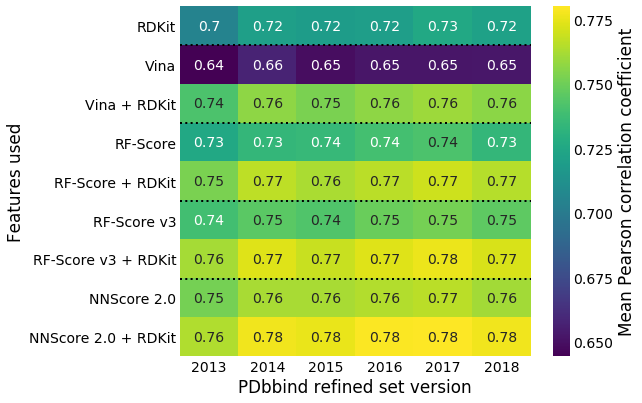

In [106]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
sns.heatmap(pd.DataFrame(mean_pearsonr).loc[order], 
            annot=True, 
            cmap='viridis', 
            cbar_kws={'label': 'Mean Pearson correlation coefficient'}, 
            ax=ax)
ax.hlines([1, 3, 5, 7], *ax.get_xlim(), linestyle=':', linewidth=2)
ax.set_xlabel('PDbbind refined set version')
ax.set_ylabel('Features used')
fig.savefig('../figures/pdbbind_all_years_refined_bootstrapping_validation.jpg', dpi=350, bbox_inches='tight')
fig.savefig('../figures/pdbbind_all_years_refined_bootstrapping_validation.eps', dpi=350, bbox_inches='tight')

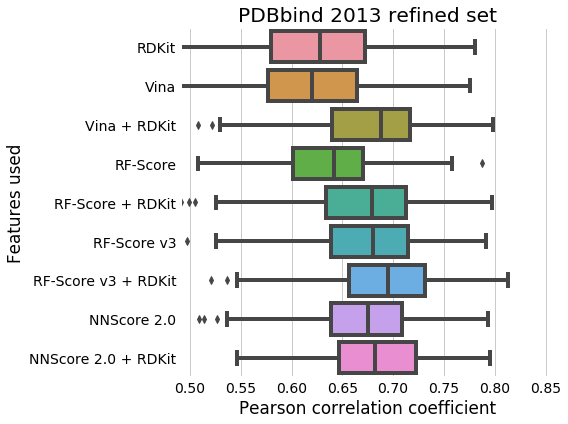

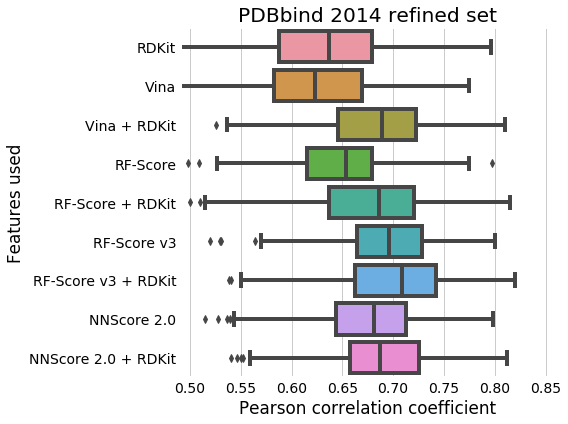

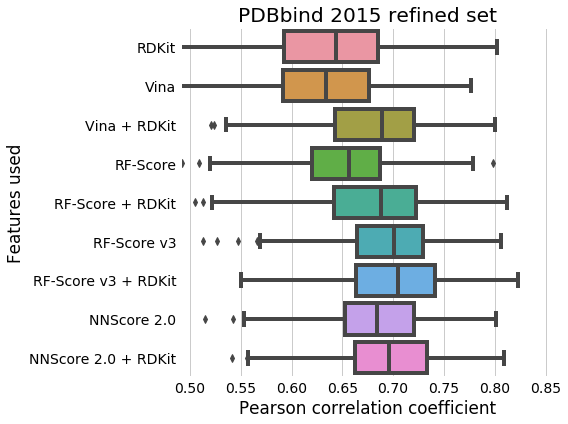

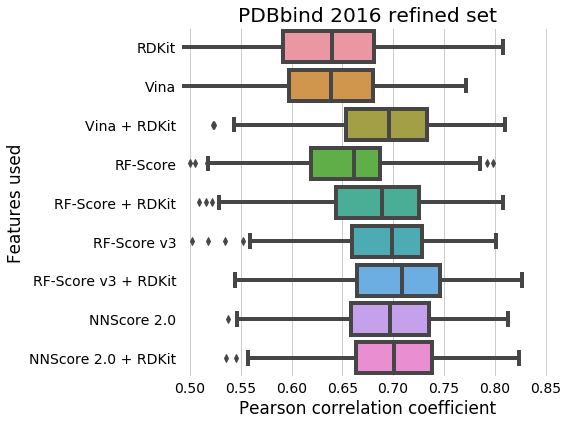

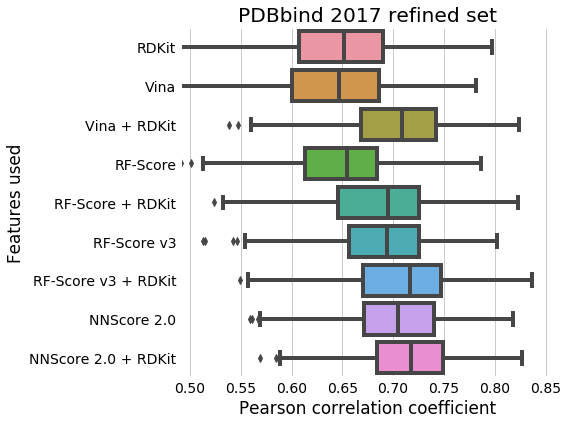

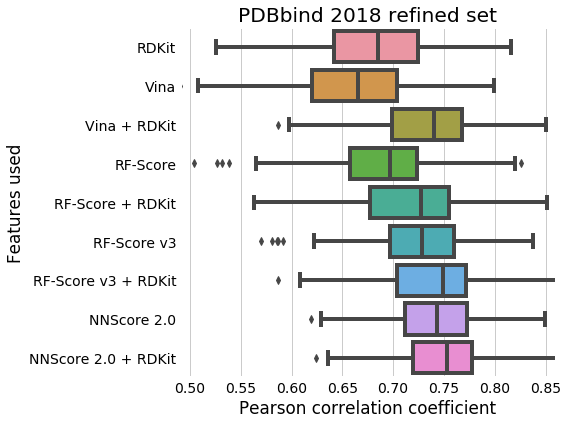

In [62]:
for year in pearsonr:
    df = pd.DataFrame(pearsonr[year])[order]https://mail.google.com/mail/u/0/#inboxhttps://mail.google.com/mail/u/0/#inbox
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sns.boxplot(x='value', y='variable', data=pd.melt(df), orient='h', ax=ax)
    #ax.set_yticklabels(order)
    ax.set_xlim(0.49, 0.86)
    ax.set_xlabel('Pearson correlation coefficient')
    ax.set_ylabel('Features used')
    ax.set_title(f'PDBbind {year} refined set')
    #fig.savefig(f'../figures/pdbbind_{year}_refined_pearsonr_boxplots.jpg', dpi=350, bbox_inches='tight')
    #fig.savefig(f'../figures/pdbbind_{year}_refined_pearsonr_boxplots.eps', dpi=350, bbox_inches='tight')

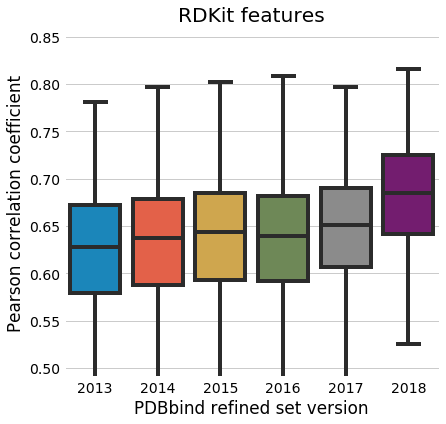

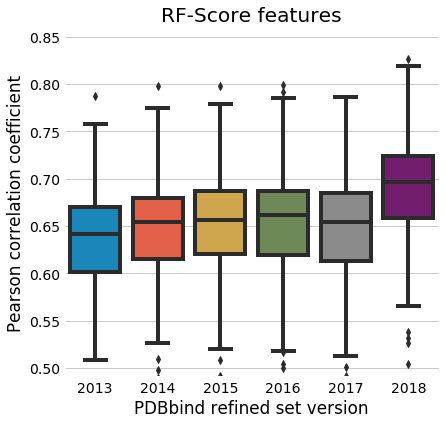

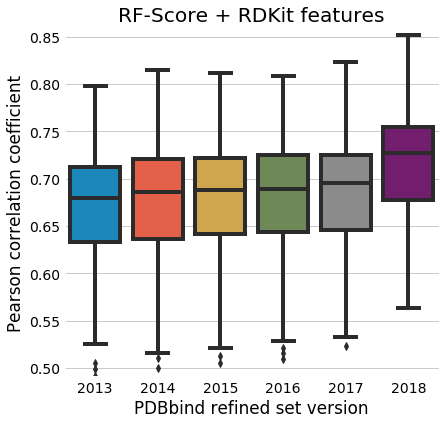

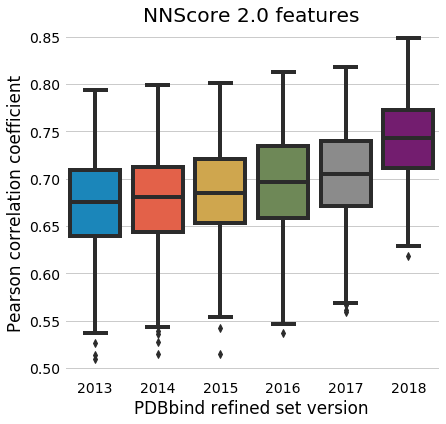

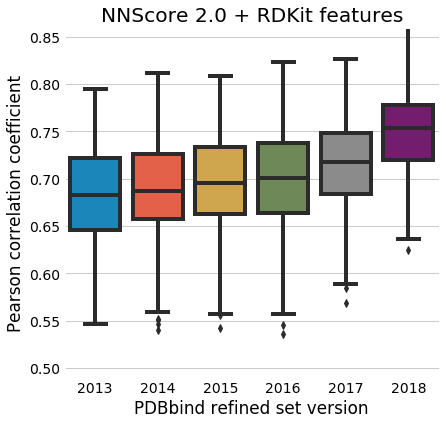

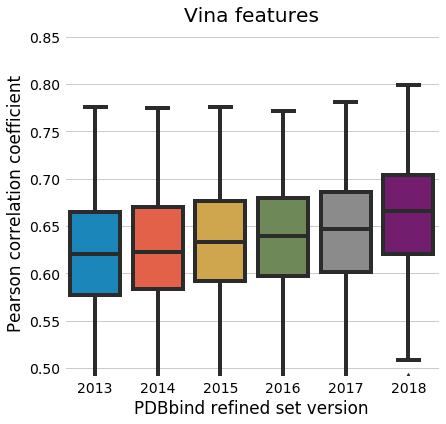

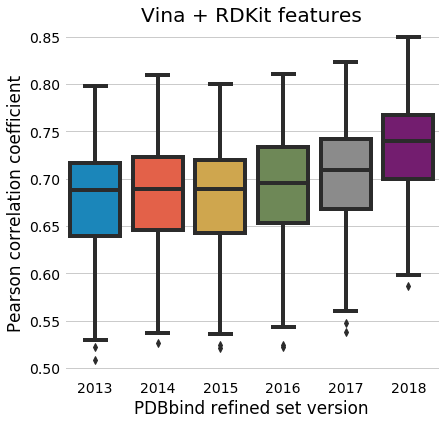

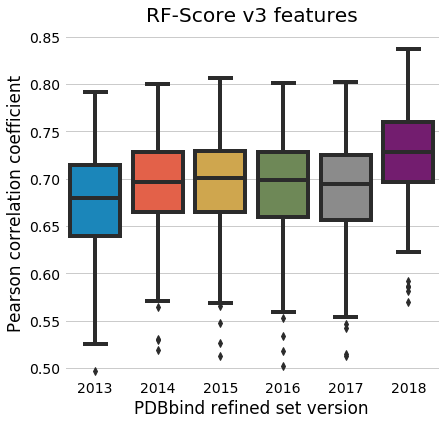

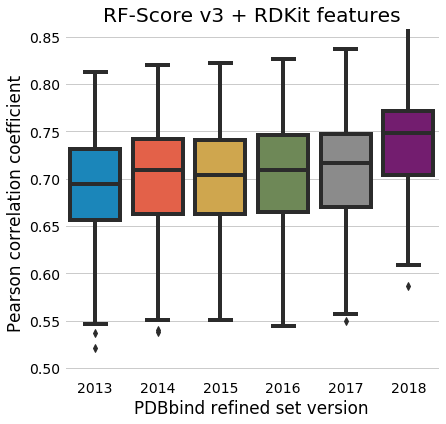

In [63]:
for f in feature_sets:
    df = pd.DataFrame({year: pearsonr[year][f] for year in pearsonr})
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sns.boxplot(data=df, orient='v', ax=ax)
    #ax.set_yticklabels(order)
    ax.set_ylim(0.49, 0.86)
    ax.set_ylabel('Pearson correlation coefficient')
    ax.set_xlabel('PDBbind refined set version')
    ax.set_title(f'{f} features')

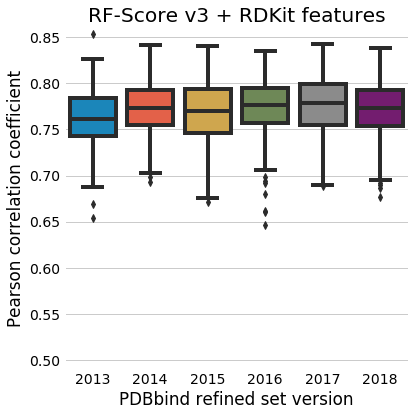

In [98]:
f = 'RF-Score v3 + RDKit'
df = pd.DataFrame({year: pearsonr[year][f] for year in pearsonr})
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.boxplot(data=df, orient='v', ax=ax)
#ax.set_yticklabels(order)
ax.set_ylim(0.49, 0.86)
ax.set_ylabel('Pearson correlation coefficient')
ax.set_xlabel('PDBbind refined set version')
ax.set_title(f'{f} features')
fig.tight_layout()
fig.savefig('../figures/rfv3_rdk_all_years_pearsonr_boxplot.jpg', dpi=350, bbox_inches='tight')
fig.savefig('../figures/rfv3_rdk_all_years_pearsonr_boxplot.eps', dpi=350, bbox_inches='tight')

# Clustering Analysis

When testing on bootstrapped samples of the PDBbind 2013 refined set, adding additional data from subsequent releases of the refined set does not improve model performance. One possible explanation for this is that the model reaches a level of learining saturdation beyond which its ability to predict the test data cannot be appreciably improved without reformulation of either the architecture or the features of the model. Instead, it is possible that the new data are sufficiently novel that the resulting increase in diversity of the training set results in a larger domain of applicability for the model.

In [3]:
with open('../data/pdbbind_refined_set_clustering.json') as f:
    clustering = json.load(f)

In [4]:
singletons = {year: {cutoff: [cluster[0] for cluster in clustering[year][cutoff] if len(cluster)==1] for cutoff in clustering[year]} for year in clustering}
clusters = {year: {cutoff: [cluster for cluster in clustering[year][cutoff] if len(cluster)>1] for cutoff in clustering[year]} for year in clustering}

In [5]:
cluster_sizes = {year: {cutoff: [len(cluster) for cluster in clusters[year][cutoff]] for cutoff in clusters[year]} for year in clusters}

In [6]:
n_clusters = {year: {cutoff: len(clusters[year][cutoff]) for cutoff in clusters[year]} for year in clusters}
n_singletons = {year: {cutoff: len(singletons[year][cutoff]) for cutoff in singletons[year]} for year in singletons}

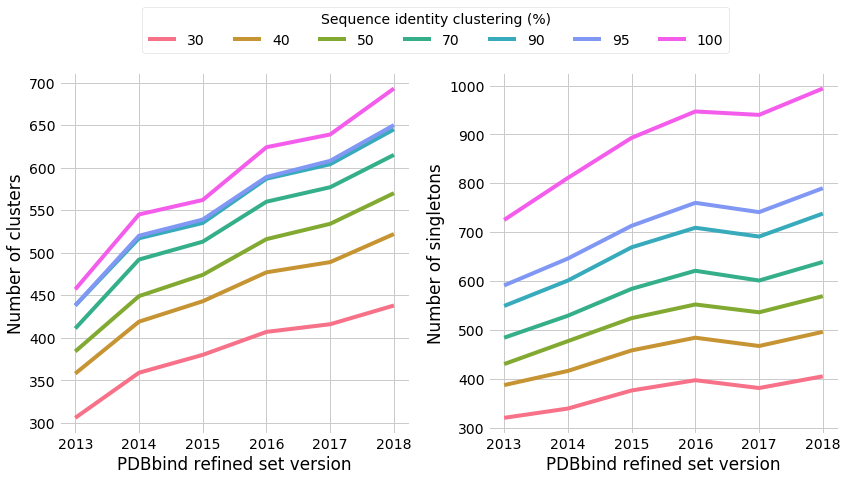

In [10]:
cutoff_order = ['30', '40', '50', '70', '90', '95', '100']
df = pd.DataFrame(n_clusters).T[cutoff_order]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(data=df, dashes=False, hue_order=cutoff_order, style_order=cutoff_order, legend=False, palette='husl', ax=ax1)
ax1.set_xlabel('PDBbind refined set version')
ax1.set_ylabel('Number of clusters')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.get_legend().set_title('Sequence identity %')

cutoff_order = ['30', '40', '50', '70', '90', '95', '100']
df = pd.DataFrame(n_singletons).T[cutoff_order]

#fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.lineplot(data=df, dashes=False, hue_order=cutoff_order, style_order=cutoff_order, palette='husl', ax=ax2)
ax2.set_xlabel('PDBbind refined set version')
ax2.set_ylabel('Number of singletons')
fig.tight_layout()
plt.legend(bbox_to_anchor=(-0.15, 1.2), ncol=7, loc='upper center')#, loc=2, borderaxespad=0.)
ax2.get_legend().set_title('Sequence identity clustering (%)')
fig.savefig('../figures/pdbbind_refined_number_of_clusters.eps', dpi=350, bbox_inches='tight')
fig.savefig('../figures/pdbbind_refined_number_of_clusters.jpg', dpi=350, bbox_inches='tight')

Bootstrap test sets from new data added in 2018. Compare performance of models trained on version 2013-2018. Does domain of applicability improve as more diverse data are added?